In [46]:
import pandas as pd
import json
import numpy as np
import sys
import requests
from pathlib import Path
from tqdm.auto import tqdm
from typing import Dict, List, Any, Optional, Union

sys.path.append(str(Path.cwd().parent))
from scripts.minsearch import Index

# Ingestion

In [47]:
acne_types_df = pd.read_csv('../data/knowledge-base/acne_types.csv', sep=';')
faqs_df = pd.read_csv('../data/knowledge-base/faqs.csv', sep=';')

In [48]:
acne_documents = acne_types_df.to_dict(orient='records')
faq_documents = faqs_df.to_dict(orient='records')

In [49]:
for doc in acne_documents:
    doc['source'] = 'acne_types'
for doc in faq_documents:
    doc['source'] = 'faqs'


In [50]:
all_documents = acne_documents + faq_documents

In [51]:
index = Index(
    text_fields=[
        'Acne Type', 'Description', 'Common Locations', 'Common Causes', 
        'Initial Treatment', 'OTC Ingredients', 'Skincare Recommendations',
        'Skincare Ingredients to Avoid', 'When to Consult Dermatologist',
        'Expected Timeline', 'Combination Considerations', 'Skin Type Adjustments',
        'Age-Specific Considerations', 'Question', 'Answer', 'Category'
    ],
    keyword_fields=['source']
)

In [52]:
index.fit(all_documents)

# RAG Flow

In [53]:
DIAGNOSIS_TEMPLATE = """
You are an expert dermatology assistant for the Acne Sense app.
Create helpful recommendations based on the PATIENT PROFILE and ACNE INFORMATION provided.
Your response should be concise, informative, and structured in these sections:
1. OVERVIEW - Brief summary of detected acne condition (1-2 sentences)
2. RECOMMENDATIONS - Specific treatment suggestions based on acne type, skin type, and age
3. SKINCARE TIPS - Practical daily skincare advice tailored to the patient
4. IMPORTANT NOTES - Any warnings, timeline expectations, or when to consult a dermatologist

Your response should directly address their specific situation without asking follow-up questions.
Base your recommendations ONLY on the knowledge provided in ACNE INFORMATION.

PATIENT PROFILE:
{patient_profile}

ACNE INFORMATION:
{acne_info}
""".strip()

QA_TEMPLATE = """
You are an expert dermatologist assistant for the Acne Sense app.
Answer the USER'S QUESTION based on the CONTEXT provided from our knowledge base.
Use only the facts from the CONTEXT when answering the QUESTION.
If you don't know the answer based on the context, say "I don't have enough information to answer that question."
Your responses should be informative, accurate, and presented in a compassionate, professional tone.

CONTEXT:
{context}

USER'S QUESTION: {query}
""".strip()

ACNE_DOC_TEMPLATE = """
Acne Type: {Acne Type}
Description: {Description}
Common Locations: {Common Locations}
Common Causes: {Common Causes}
Initial Treatment: {Initial Treatment}
OTC Ingredients: {OTC Ingredients}
Skincare Recommendations: {Skincare Recommendations}
Ingredients to Avoid: {Skincare Ingredients to Avoid}
When to Consult Dermatologist: {When to Consult Dermatologist}
Expected Timeline: {Expected Timeline}
Combination Considerations: {Combination Considerations}
Skin Type Adjustments: {Skin Type Adjustments}
Age-Specific Considerations: {Age-Specific Considerations}
""".strip()

FAQ_DOC_TEMPLATE = """
Question: {Question}
Answer: {Answer}
Category: {Category}
""".strip()

In [54]:
def search(query: str, filter_dict: Dict = None, num_results: int = 10) -> List[Dict]:
    """Search the knowledge base for relevant documents"""
    filter_dict = filter_dict or {}
    
    results = index.search(
        query=query,
        filter_dict=filter_dict,
        boost_dict={},
        num_results=num_results
    )
    
    return results


In [55]:
def build_context_from_documents(documents: List[Dict]) -> str:
    """Build context string from search result documents"""
    context = ""
    
    for doc in documents:
        if doc.get('source') == 'acne_types':
            try:
                context += ACNE_DOC_TEMPLATE.format(**doc) + "\n\n"
            except KeyError:
                # Handle missing keys
                pass
        elif doc.get('source') == 'faqs':
            try:
                context += FAQ_DOC_TEMPLATE.format(**doc) + "\n\n"
            except KeyError:
                # Handle missing keys
                pass
    
    return context

In [56]:
def call_llm(prompt: str, model: str = "qwen2:7b") -> str:
    """Get response from Ollama LLM"""
    try:
        response = requests.post(
            'http://localhost:11434/api/generate',
            json={
                "model": model,
                "prompt": prompt,
                "stream": False
            },
            timeout=120  
        )
        
        if response.status_code == 200:
            return response.json().get('response', 'No response generated')
        else:
            return f"Error: {response.status_code} - {response.text}"
    except Exception as e:
        return f"Error connecting to Ollama: {str(e)}"

In [57]:
def process_diagnosis(acne_types: List[str], user_info: Dict[str, Any], model: str = "qwen2:7b") -> str:
    """Process CV diagnosis results and provide recommendations"""

    patient_profile = f"""
    Age: {user_info.get('age', 'Unknown')}
    Skin Type: {user_info.get('skin_type', 'Unknown')}
    Skin Tone: {user_info.get('skin_tone', 'Unknown')}
    Sensitivity: {user_info.get('skin_sensitivity', 'Unknown')}
    """.strip()
    
    # Retrieve relevant acne information
    acne_info = ""
    
    for acne_type in acne_types:
        search_results = search(
            query=acne_type,
            filter_dict={"source": "acne_types"},
            num_results=1
        )
        
        if search_results:
            acne_info += build_context_from_documents(search_results)
    
    # If we have multiple acne types, search for combination considerations
    if len(acne_types) > 1:
        combination_query = " ".join(acne_types) + " combination"
        combo_results = search(
            query=combination_query,
            num_results=3
        )
        if combo_results:
            acne_info += "\n\nCombination Considerations:\n"
            acne_info += build_context_from_documents(combo_results)
    
    # Build the final prompt
    prompt = DIAGNOSIS_TEMPLATE.format(
        patient_profile=patient_profile,
        acne_info=acne_info
    )
    
    # Get response from LLM
    response = call_llm(prompt, model)
    
    return response

In [58]:
def answer_question(query: str, model: str = "qwen2:7b") -> str:
    """Answer a user question using the knowledge base"""
    # Get relevant context from the search index
    search_results = search(query, num_results=5)
    
    # Build context from search results
    context = build_context_from_documents(search_results)
    
    # Build the prompt with the context
    prompt = QA_TEMPLATE.format(context=context, query=query)
    
    # Get response from the model
    answer = call_llm(prompt, model)
    
    return answer

# RAG Test

In [59]:
print("Test Case 1: Single Acne Type (Pustule)")
acne_types1 = ["Pustule"]
user_info1 = {
    "age": 17,
    "skin_type": "Oily", 
    "skin_tone": "Light",
    "skin_sensitivity": "Low"
}

print(f"Acne Types: {acne_types1}")
print(f"User Info: {user_info1}")
response1 = process_diagnosis(acne_types1, user_info1)
print("\nDiagnosis Response:")
print(response1)
print("-" * 80)

Test Case 1: Single Acne Type (Pustule)
Acne Types: ['Pustule']
User Info: {'age': 17, 'skin_type': 'Oily', 'skin_tone': 'Light', 'skin_sensitivity': 'Low'}

Diagnosis Response:
OVERVIEW:
You have mild-to-moderate pustular acne primarily on the face (cheeks and chin), back, and shoulders. It's characterized by red inflamed bumps with pus-filled centers, likely due to bacterial proliferation, excess oil, and inflammation.

RECOMMENDATIONS:
1. **Initial Treatment**: Use a benzoyl peroxide or topical antibiotic like erythromycin as your primary treatment for pustules.
2. **OTC Ingredients**: Incorporate benzoyl peroxide or salicylic acid products into your routine to address acne and reduce inflammation.
3. **Skincare Products**: Opt for oil-free cleansers, non-comedogenic serums, and clay masks that help draw out excess sebum.

SKINCARE TIPS:
1. Wash your face twice a day with a gentle oil-free cleanser designed for oily skin types.
2. Apply a lightweight moisturizer suitable for oily sk

In [60]:
print("Test Case 2: Multiple Acne Types (Cyst + Blackhead)")
acne_types2 = ["Cyst", "Blackhead"]
user_info2 = {
    "age": 32,
    "skin_type": "Combination",
    "skin_tone": "Medium", 
    "skin_sensitivity": "High"
}

print(f"Acne Types: {acne_types2}")
print(f"User Info: {user_info2}")
response2 = process_diagnosis(acne_types2, user_info2)
print("\nDiagnosis Response:")
print(response2)
print("-" * 80)

Test Case 2: Multiple Acne Types (Cyst + Blackhead)
Acne Types: ['Cyst', 'Blackhead']
User Info: {'age': 32, 'skin_type': 'Combination', 'skin_tone': 'Medium', 'skin_sensitivity': 'High'}

Diagnosis Response:
OVERVIEW:
The patient has a mixed acne condition featuring both cystic acne and blackheads. This combination requires dual approach treatment focusing on inflammation management and pore hygiene.

RECOMMENDATIONS:
1. **Cystic Acne**: Utilize oral antibiotics like doxycycline, intralesional steroid injections for immediate relief, and consider isotretinoin as a long-term solution if needed.
2. **Blackheads**: Employ salicylic acid, retinoids (e.g., adapalene), and chemical exfoliants to address the T-zone concerns associated with excess sebum and dead skin cells.

SKINCARE TIPS:
- Use toners containing exfoliating ingredients like salicylic acid.
- Incorporate clay masks or charcoal products for deep cleansing.
- Choose oil-free primers to prevent pore clogging.

AVOID INGREDIENTS/

In [61]:
questions = [
    "Is my skin photo data stored or shared?",
    # "How accurate is the AI in detecting acne types?",
    # "Does the app work for all skin tones?",
    "Can Acne Sense replace a dermatologist?"
]

for i, question in enumerate(questions, 1):
    print(f"Question {i}: {question}")
    answer = answer_question(question)
    print(f"Answer: {answer}")
    print("-" * 80)

Question 1: Is my skin photo data stored or shared?
Answer: No. Photos are processed anonymously and deleted immediately after analysis. We comply with GDPR and HIPAA standards to protect user privacy.
--------------------------------------------------------------------------------
Question 2: Can Acne Sense replace a dermatologist?
Answer: No. While Acne Sense provides initial guidance and valuable insights on acne management, it cannot fully replace the expertise of a dermatologist. Severe cases involving cysts, nodules, or complications like Acne Fulminans require professional evaluation by a specialist due to their severity and potential health impacts. Similarly, conditions such as Excoriated Acne that are worsened by compulsive picking or scratching necessitate not only medical treatment but also possibly behavioral therapy. Acne of the Acne Mechanica type triggered by physical factors also may need adjustments in lifestyle, which might require professional advice to eliminate tr

In [62]:
custom_question = "What are the best treatments for cystic acne for someone with sensitive skin?"
print(f"Custom Question: {custom_question}")
custom_answer = answer_question(custom_question)
print(f"Answer: {custom_answer}")
print("-" * 80)

print("Testing completed!")

Custom Question: What are the best treatments for cystic acne for someone with sensitive skin?
Answer: For cystic acne in a person with sensitive skin, it is recommended to prioritize gentle and soothing treatments. First, consider focusing on barrier-repair creams that can help maintain your skin's natural moisture levels while minimizing irritation.

You might want to use hypoallergenic products that avoid harsh ingredients such as alcohol and fragrances which could further irritate sensitive skin. Barrier-repairing moisturizers are particularly useful in maintaining the integrity of your skin barrier, helping to prevent acne from worsening due to barrier damage.

For cleansing, opt for gentle PH-balanced cleansers instead of those that are stripping or contain harsh surfactants. Additionally, incorporating water-based formulas for toners and oils-free primers can help maintain a non-greasy finish on sensitive skin.

In terms of active ingredients, focus on using anti-inflammatory an

# Retrieval Evaluation

In [63]:
df_eval_questions = pd.read_csv('../data/knowledge-base/acne_retrieval_eval_questions.csv')

In [64]:
ground_truth = df_eval_questions.to_dict(orient='records')

In [65]:
def hit_rate(relevance_total):
    cnt = 0
    for line in relevance_total:
        if True in line:
            cnt = cnt + 1
    return cnt / len(relevance_total)

In [66]:
def mrr(relevance_total):
    total_score = 0.0
    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)
    return total_score / len(relevance_total)


In [67]:
def evaluate(ground_truth, search_function):
    relevance_total = []
    
    if ground_truth and len(ground_truth) > 0:
        print(f"Available keys: {list(ground_truth[0].keys())}")
        
    for q in tqdm(ground_truth, desc="Evaluating questions"):
        doc_id = q['id']
        results = search_function(q['question'])
        
        # Check if the retrieved documents match the ground truth
        relevance = []
        for doc in results:
            is_relevant = False
            if doc.get('source') == 'acne_types':
                is_relevant = doc.get('Acne Type') == doc_id
            elif doc.get('source') == 'faqs':
                is_relevant = doc.get('Question') == doc_id
            relevance.append(is_relevant)
        
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [68]:
baseline_results = evaluate(ground_truth, lambda q: search(q))

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/140 [00:00<?, ?it/s]

In [69]:
baseline_results

{'hit_rate': 0.8, 'mrr': 0.4149121315192746}

# Simple Tuning

In [70]:
import random

def simple_optimize(param_ranges, objective_function, n_iterations=10):
    """Simple random search optimization for boost parameters"""
    best_params = None
    best_score = float('-inf')  # We're maximizing MRR

    for _ in range(n_iterations):
        # Generate random parameters within the specified ranges
        current_params = {}
        for param, (min_val, max_val) in param_ranges.items():
            if isinstance(min_val, int) and isinstance(max_val, int):
                current_params[param] = random.randint(min_val, max_val)
            else:
                current_params[param] = random.uniform(min_val, max_val)
        
        # Evaluate the objective function
        current_score = objective_function(current_params)
        
        # Update best if current is better
        if current_score > best_score:
            best_score = current_score
            best_params = current_params
    
    return best_params, best_score

In [71]:
def create_splits():
    length = len(df_eval_questions)
    random.seed(42)
    df_validation = df_eval_questions.iloc[:length//2] 
    df_test = df_eval_questions.iloc[length//2:]        
    
    val_data = df_validation.to_dict(orient='records')
    test_data = df_test.to_dict(orient='records')
    
    return val_data, test_data

val_data, test_data = create_splits()

In [72]:
param_ranges = {
    'Acne Type': (0.0, 3.0),
    'Description': (0.0, 3.0),
    'Common Locations': (0.0, 3.0),
    'Common Causes': (0.0, 3.0),
    'Initial Treatment': (0.0, 3.0),
    'OTC Ingredients': (0.0, 3.0),
    'Skincare Recommendations': (0.0, 3.0),
    'Skincare Ingredients to Avoid': (0.0, 3.0),
    'When to Consult Dermatologist': (0.0, 3.0),
    'Expected Timeline': (0.0, 3.0),
    'Combination Considerations': (0.0, 3.0),
    'Skin Type Adjustments': (0.0, 3.0),
    'Age-Specific Considerations': (0.0, 3.0),
    'Question': (0.0, 3.0),
    'Answer': (0.0, 3.0),
    'Category': (0.0, 3.0)
}


In [73]:
def boosted_search(query, boost_params=None):
    """Search function with configurable boost parameters"""
    if boost_params is None:
        boost_params = {}
    
    results = index.search(
        query=query,
        filter_dict={},
        boost_dict=boost_params,
        num_results=10
    )
    
    return results

In [74]:
def objective(boost_params):
    """Objective function: MRR on validation set"""
    def search_function(q):
        return boosted_search(q, boost_params)
    
    results = evaluate(val_data, search_function)
    return results['mrr']

In [75]:
print("Starting optimization...")
best_params, best_score = simple_optimize(param_ranges, objective, n_iterations=20)
print(f"Best MRR score: {best_score}")
print("Best parameters:")
for field, value in best_params.items():
    print(f"  {field}: {value:.2f}")

Starting optimization...
Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Best MRR score: 0.6458276643990931
Best parameters:
  Acne Type: 1.92
  Description: 0.08
  Common Locations: 0.83
  Common Causes: 0.67
  Initial Treatment: 2.21
  OTC Ingredients: 2.03
  Skincare Recommendations: 2.68
  Skincare Ingredients to Avoid: 0.26
  When to Consult Dermatologist: 1.27
  Expected Timeline: 0.09
  Combination Considerations: 0.66
  Skin Type Adjustments: 1.52
  Age-Specific Considerations: 0.08
  Question: 0.60
  Answer: 1.95
  Category: 1.63


In [76]:
def improved_search(query):
    """Search function with optimized boost parameters"""
    boost = best_params
    
    results = index.search(
        query=query,
        filter_dict={},
        boost_dict=boost,
        num_results=10
    )
    
    return results

In [77]:
# Compare baseline search vs improved search on test data
print("Evaluating on test data...")
baseline_test_results = evaluate(test_data, lambda q: search(q))
improved_test_results = evaluate(test_data, lambda q: improved_search(q))

print(f"Baseline results: {baseline_test_results}")
print(f"Improved results: {improved_test_results}")

# Calculate relative improvement
mrr_improvement = ((improved_test_results['mrr'] - baseline_test_results['mrr']) / 
                  baseline_test_results['mrr']) * 100
hit_improvement = ((improved_test_results['hit_rate'] - baseline_test_results['hit_rate']) / 
                   baseline_test_results['hit_rate']) * 100

print(f"MRR improvement: {mrr_improvement:.1f}%")
print(f"Hit rate improvement: {hit_improvement:.1f}%")

Evaluating on test data...
Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Baseline results: {'hit_rate': 0.7, 'mrr': 0.25566326530612243}
Improved results: {'hit_rate': 0.8142857142857143, 'mrr': 0.31752834467120167}
MRR improvement: 24.2%
Hit rate improvement: 16.3%


# Optuna Tuning

In [78]:
import optuna

In [79]:
def optimize_with_optuna(n_trials=30):
    """Use Optuna to find optimal boost parameters"""
    
    def objective(trial):
        # Define the parameters to optimize
        boost_params = {
            'Acne Type': trial.suggest_float('Acne Type', 0.0, 3.0),
            'Description': trial.suggest_float('Description', 0.0, 3.0),
            'Common Locations': trial.suggest_float('Common Locations', 0.0, 3.0),
            'Common Causes': trial.suggest_float('Common Causes', 0.0, 3.0),
            'Initial Treatment': trial.suggest_float('Initial Treatment', 0.0, 3.0),
            'OTC Ingredients': trial.suggest_float('OTC Ingredients', 0.0, 3.0),
            'Skincare Recommendations': trial.suggest_float('Skincare Recommendations', 0.0, 3.0),
            'Skincare Ingredients to Avoid': trial.suggest_float('Skincare Ingredients to Avoid', 0.0, 3.0),
            'When to Consult Dermatologist': trial.suggest_float('When to Consult Dermatologist', 0.0, 3.0),
            'Expected Timeline': trial.suggest_float('Expected Timeline', 0.0, 3.0),
            'Combination Considerations': trial.suggest_float('Combination Considerations', 0.0, 3.0),
            'Skin Type Adjustments': trial.suggest_float('Skin Type Adjustments', 0.0, 3.0),
            'Age-Specific Considerations': trial.suggest_float('Age-Specific Considerations', 0.0, 3.0),
            'Question': trial.suggest_float('Question', 0.0, 3.0),
            'Answer': trial.suggest_float('Answer', 0.0, 3.0),
            'Category': trial.suggest_float('Category', 0.0, 3.0)
        }
        
        # Define the search function
        def search_function(q):
            return boosted_search(q, boost_params)
        
        # Evaluate and return MRR score
        results = evaluate(val_data, search_function)
        return results['mrr']
    
    # Create a study that maximizes the objective
    study = optuna.create_study(direction='maximize', 
                                sampler=optuna.samplers.TPESampler(seed=42))
    
    # Start the optimization
    study.optimize(objective, n_trials=n_trials)
    
    return study

In [80]:
print("Starting Optuna optimization...")
study = optimize_with_optuna(n_trials=30)

# Get the best parameters
optuna_best_params = study.best_params
optuna_best_score = study.best_value

print(f"Best MRR score: {optuna_best_score}")
print("Best parameters:")
for field, value in optuna_best_params.items():
    print(f"  {field}: {value:.2f}")

[I 2025-05-19 21:55:16,938] A new study created in memory with name: no-name-fb8d6283-b872-4f6d-83e2-e6e6d95f0ff1


Starting Optuna optimization...
Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:17,378] Trial 0 finished with value: 0.45251133786848075 and parameters: {'Acne Type': 1.1236203565420875, 'Description': 2.8521429192297485, 'Common Locations': 2.1959818254342154, 'Common Causes': 1.7959754525911098, 'Initial Treatment': 0.46805592132730955, 'OTC Ingredients': 0.46798356100860794, 'Skincare Recommendations': 0.17425083650459838, 'Skincare Ingredients to Avoid': 2.5985284373248057, 'When to Consult Dermatologist': 1.8033450352296265, 'Expected Timeline': 2.1242177333881367, 'Combination Considerations': 0.06175348288740734, 'Skin Type Adjustments': 2.909729556485983, 'Age-Specific Considerations': 2.497327922401265, 'Question': 0.6370173320348285, 'Answer': 0.5454749016213019, 'Category': 0.5502135295603015}. Best is trial 0 with value: 0.45251133786848075.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:17,814] Trial 1 finished with value: 0.4936791383219955 and parameters: {'Acne Type': 0.9127267288786132, 'Description': 1.5742692948967134, 'Common Locations': 1.2958350559263474, 'Common Causes': 0.8736874205941257, 'Initial Treatment': 1.8355586841671383, 'OTC Ingredients': 0.4184815819561255, 'Skincare Recommendations': 0.8764339456056545, 'Skincare Ingredients to Avoid': 1.099085529881075, 'When to Consult Dermatologist': 1.3682099526511078, 'Expected Timeline': 2.3555278841790406, 'Combination Considerations': 0.5990213464750792, 'Skin Type Adjustments': 1.5427033152408347, 'Age-Specific Considerations': 1.7772437065861273, 'Question': 0.13935123815999317, 'Answer': 1.822634555704315, 'Category': 0.5115723710618746}. Best is trial 1 with value: 0.4936791383219955.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:18,267] Trial 2 finished with value: 0.29789115646258507 and parameters: {'Acne Type': 0.19515477895583855, 'Description': 2.84665661176, 'Common Locations': 2.896896099223678, 'Common Causes': 2.4251920443493833, 'Initial Treatment': 0.9138413075201121, 'OTC Ingredients': 0.2930163420191516, 'Skincare Recommendations': 2.052699079536471, 'Skincare Ingredients to Avoid': 1.320457481218804, 'When to Consult Dermatologist': 0.3661147045343365, 'Expected Timeline': 1.4855307303338106, 'Combination Considerations': 0.10316556334565519, 'Skin Type Adjustments': 2.7279612062363463, 'Age-Specific Considerations': 0.7763399448000508, 'Question': 1.987566853061946, 'Answer': 0.9351332282682329, 'Category': 1.5602040635334324}. Best is trial 1 with value: 0.4936791383219955.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:18,697] Trial 3 finished with value: 0.506700680272109 and parameters: {'Acne Type': 1.640130838029839, 'Description': 0.5545633665765811, 'Common Locations': 2.9087538832936755, 'Common Causes': 2.3253984700833437, 'Initial Treatment': 2.8184968246925672, 'OTC Ingredients': 2.6844820512829464, 'Skincare Recommendations': 1.7936999364332555, 'Skincare Ingredients to Avoid': 2.7656227050693505, 'When to Consult Dermatologist': 0.2654775061557585, 'Expected Timeline': 0.5879485872574356, 'Combination Considerations': 0.1356818667316142, 'Skin Type Adjustments': 0.975990992289793, 'Age-Specific Considerations': 1.166031869068446, 'Question': 0.8140470953216877, 'Answer': 2.486212527455788, 'Category': 1.0702599800807677}. Best is trial 3 with value: 0.506700680272109.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:19,130] Trial 4 finished with value: 0.42946145124716556 and parameters: {'Acne Type': 0.8428035290621423, 'Description': 1.6280882494747453, 'Common Locations': 0.42277267492428794, 'Common Causes': 2.406590942262119, 'Initial Treatment': 0.22365193103931247, 'OTC Ingredients': 2.960660809801552, 'Skincare Recommendations': 2.3167343078899725, 'Skincare Ingredients to Avoid': 0.5961470446025172, 'When to Consult Dermatologist': 0.016566351370807197, 'Expected Timeline': 2.4463842853645024, 'Combination Considerations': 2.120572031542851, 'Skin Type Adjustments': 2.1870215041229617, 'Age-Specific Considerations': 2.3138110400578373, 'Question': 0.22213395520227108, 'Answer': 1.0753971856328177, 'Category': 0.34760717857538914}. Best is trial 3 with value: 0.506700680272109.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:19,563] Trial 5 finished with value: 0.6485260770975058 and parameters: {'Acne Type': 2.5893102776267805, 'Description': 1.8698943804826738, 'Common Locations': 0.9926940745579476, 'Common Causes': 0.1906750508580709, 'Initial Treatment': 0.9329469651469866, 'OTC Ingredients': 0.9755499660802411, 'Skincare Recommendations': 2.1888185350141924, 'Skincare Ingredients to Avoid': 1.9126724140656393, 'When to Consult Dermatologist': 2.6616382277289796, 'Expected Timeline': 1.4166447754858478, 'Combination Considerations': 0.3587827378149051, 'Skin Type Adjustments': 2.1397343616689852, 'Age-Specific Considerations': 2.2823551458506923, 'Question': 1.6838315927084886, 'Answer': 2.3129015398636827, 'Category': 1.4813867890931722}. Best is trial 5 with value: 0.6485260770975058.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:19,998] Trial 6 finished with value: 0.6187698412698412 and parameters: {'Acne Type': 1.568198488145982, 'Description': 1.282623055075649, 'Common Locations': 0.07625738023228557, 'Common Causes': 0.32367428097991335, 'Initial Treatment': 0.09428755706020275, 'OTC Ingredients': 1.909231233791341, 'Skincare Recommendations': 0.94306794322898, 'Skincare Ingredients to Avoid': 1.5257120734941083, 'When to Consult Dermatologist': 2.722699421778279, 'Expected Timeline': 0.7478766874466248, 'Combination Considerations': 1.2311487691068892, 'Skin Type Adjustments': 2.266653415629146, 'Age-Specific Considerations': 0.6863944964748674, 'Question': 0.23093972948637898, 'Answer': 0.8692543587413041, 'Category': 0.48366386176201326}. Best is trial 5 with value: 0.6485260770975058.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:20,435] Trial 7 finished with value: 0.63921768707483 and parameters: {'Acne Type': 2.7890929570277194, 'Description': 2.424361138693251, 'Common Locations': 1.9002112695312703, 'Common Causes': 2.614381770563153, 'Initial Treatment': 2.4110162306973435, 'OTC Ingredients': 0.5597101766581075, 'Skincare Recommendations': 2.677676995469933, 'Skincare Ingredients to Avoid': 1.6180267257469523, 'When to Consult Dermatologist': 2.4223204654921875, 'Expected Timeline': 2.6882738997704796, 'Combination Considerations': 0.9540104249155916, 'Skin Type Adjustments': 0.3301557735830303, 'Age-Specific Considerations': 0.683805487625825, 'Question': 1.281323365878769, 'Answer': 2.4540442977674792, 'Category': 2.5821917497690303}. Best is trial 5 with value: 0.6485260770975058.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:20,866] Trial 8 finished with value: 0.2832312925170068 and parameters: {'Acne Type': 0.02085639159357211, 'Description': 1.5322419077326972, 'Common Locations': 1.252233009446337, 'Common Causes': 0.6663234314121907, 'Initial Treatment': 0.3595961020010484, 'OTC Ingredients': 1.0128455142108839, 'Skincare Recommendations': 2.8287291117375575, 'Skincare Ingredients to Avoid': 0.9696087960622657, 'When to Consult Dermatologist': 1.5563718652300982, 'Expected Timeline': 2.1090568766855338, 'Combination Considerations': 1.090888807137882, 'Skin Type Adjustments': 2.915346248162882, 'Age-Specific Considerations': 2.8873418848263337, 'Question': 0.7553468874760925, 'Answer': 1.4917455176771564, 'Category': 0.902634929450309}. Best is trial 5 with value: 0.6485260770975058.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:21,315] Trial 9 finished with value: 0.3243367346938776 and parameters: {'Acne Type': 0.8545214831324028, 'Description': 0.11066084206359839, 'Common Locations': 1.8286930019396905, 'Common Causes': 1.5080370696865844, 'Initial Treatment': 0.15443625374996806, 'OTC Ingredients': 0.8359393927098343, 'Skincare Recommendations': 2.724797657899961, 'Skincare Ingredients to Avoid': 0.7186856720009173, 'When to Consult Dermatologist': 0.4346846162736693, 'Expected Timeline': 1.468358280832689, 'Combination Considerations': 2.956951362331802, 'Skin Type Adjustments': 0.7261658145345012, 'Age-Specific Considerations': 2.0164066422176354, 'Question': 2.284858845986153, 'Answer': 0.712912631977199, 'Category': 2.1846490458355787}. Best is trial 5 with value: 0.6485260770975058.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:21,788] Trial 10 finished with value: 0.6654705215419503 and parameters: {'Acne Type': 2.936368707589074, 'Description': 2.164840024069656, 'Common Locations': 0.791582745275468, 'Common Causes': 0.05388562684445919, 'Initial Treatment': 1.291281361603186, 'OTC Ingredients': 1.6065220333621744, 'Skincare Recommendations': 1.2682539750584236, 'Skincare Ingredients to Avoid': 2.069924419974333, 'When to Consult Dermatologist': 2.9093705152012133, 'Expected Timeline': 0.03693350869481238, 'Combination Considerations': 1.771424068781189, 'Skin Type Adjustments': 1.6755741923378706, 'Age-Specific Considerations': 1.3870337592649364, 'Question': 2.9338116745963254, 'Answer': 2.976492192385895, 'Category': 1.7686555624686506}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:22,257] Trial 11 finished with value: 0.6649943310657598 and parameters: {'Acne Type': 2.9847460852283687, 'Description': 2.147380289940478, 'Common Locations': 0.800973218836109, 'Common Causes': 0.010949927328783679, 'Initial Treatment': 1.3125987561598202, 'OTC Ingredients': 1.5833366790900962, 'Skincare Recommendations': 1.4061156566635271, 'Skincare Ingredients to Avoid': 2.12622714089156, 'When to Consult Dermatologist': 2.9725403057172444, 'Expected Timeline': 0.10075765480341636, 'Combination Considerations': 1.8518485029671548, 'Skin Type Adjustments': 1.6594972931242864, 'Age-Specific Considerations': 1.304434868768511, 'Question': 2.9454778593900777, 'Answer': 2.9980873159246544, 'Category': 1.754435222955143}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:22,730] Trial 12 finished with value: 0.6405725623582769 and parameters: {'Acne Type': 2.2738548281586484, 'Description': 2.276652376664465, 'Common Locations': 0.7354998548129261, 'Common Causes': 0.05496755305937079, 'Initial Treatment': 1.6381506214851629, 'OTC Ingredients': 1.7999964533577608, 'Skincare Recommendations': 1.3814492278162172, 'Skincare Ingredients to Avoid': 2.204790092315021, 'When to Consult Dermatologist': 2.9984004220226605, 'Expected Timeline': 0.05574971383971855, 'Combination Considerations': 1.8785536241940166, 'Skin Type Adjustments': 1.3104832431776652, 'Age-Specific Considerations': 1.3569789386328253, 'Question': 2.9584509936760934, 'Answer': 2.991818986309248, 'Category': 1.915442120671387}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:23,192] Trial 13 finished with value: 0.6584240362811792 and parameters: {'Acne Type': 2.2672801283375374, 'Description': 2.194580274939748, 'Common Locations': 0.5919356132550717, 'Common Causes': 0.8902660901557136, 'Initial Treatment': 1.0835097314503113, 'OTC Ingredients': 1.4809098611957914, 'Skincare Recommendations': 1.2901263128155709, 'Skincare Ingredients to Avoid': 0.06274069945021132, 'When to Consult Dermatologist': 2.2089304482241956, 'Expected Timeline': 0.014046475117597934, 'Combination Considerations': 1.8879859980894467, 'Skin Type Adjustments': 1.6467705468886835, 'Age-Specific Considerations': 0.011747739986945893, 'Question': 2.9615394580463374, 'Answer': 0.03953764314277053, 'Category': 2.818332875188797}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:23,656] Trial 14 finished with value: 0.6431519274376418 and parameters: {'Acne Type': 2.958818886046117, 'Description': 0.9671730559929563, 'Common Locations': 0.24502265915131205, 'Common Causes': 0.41777356874168353, 'Initial Treatment': 1.953026497766552, 'OTC Ingredients': 2.0858761823255367, 'Skincare Recommendations': 0.44106373457650316, 'Skincare Ingredients to Avoid': 2.2605510349870777, 'When to Consult Dermatologist': 2.997326405368211, 'Expected Timeline': 0.5987758910382622, 'Combination Considerations': 2.501095126930382, 'Skin Type Adjustments': 1.8807558614440338, 'Age-Specific Considerations': 1.660600193957384, 'Question': 2.480601932897512, 'Answer': 2.9651587388761556, 'Category': 2.0512049273685715}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:24,126] Trial 15 finished with value: 0.6279024943310659 and parameters: {'Acne Type': 2.329752449242664, 'Description': 1.9949071904781357, 'Common Locations': 1.0072514881784076, 'Common Causes': 1.2028987129567483, 'Initial Treatment': 1.2955733579990312, 'OTC Ingredients': 1.5724874676982958, 'Skincare Recommendations': 0.9642134667550557, 'Skincare Ingredients to Avoid': 2.0408138195278287, 'When to Consult Dermatologist': 2.0693012708431624, 'Expected Timeline': 1.0462904061966198, 'Combination Considerations': 1.5784419349259837, 'Skin Type Adjustments': 1.1598873971669634, 'Age-Specific Considerations': 1.0987888622826607, 'Question': 2.5485156377859197, 'Answer': 1.9884379997182098, 'Category': 1.4823895028263423}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:24,596] Trial 16 finished with value: 0.5823526077097507 and parameters: {'Acne Type': 1.876749416237609, 'Description': 2.491587175298849, 'Common Locations': 0.8218668167631161, 'Common Causes': 0.0019507329621055725, 'Initial Treatment': 2.1957508283486424, 'OTC Ingredients': 2.378984398607914, 'Skincare Recommendations': 1.7556358177139957, 'Skincare Ingredients to Avoid': 2.930106975100787, 'When to Consult Dermatologist': 0.9375149202963204, 'Expected Timeline': 0.23336552142530936, 'Combination Considerations': 2.4303835058046284, 'Skin Type Adjustments': 1.8475736857484755, 'Age-Specific Considerations': 0.1878986087686112, 'Question': 2.7799012227003534, 'Answer': 2.6628242670728888, 'Category': 2.3581920975071036}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:25,093] Trial 17 finished with value: 0.6413208616780045 and parameters: {'Acne Type': 2.976027976142453, 'Description': 1.1150411465477468, 'Common Locations': 1.5285869535329517, 'Common Causes': 2.9924094854429213, 'Initial Treatment': 1.5152265641173044, 'OTC Ingredients': 1.3211114671459918, 'Skincare Recommendations': 0.4930309575785081, 'Skincare Ingredients to Avoid': 2.492252844164616, 'When to Consult Dermatologist': 2.4872526150854677, 'Expected Timeline': 0.4171083843983547, 'Combination Considerations': 1.4780203284223226, 'Skin Type Adjustments': 0.6451997212892933, 'Age-Specific Considerations': 1.469927020544802, 'Question': 2.0657439948939786, 'Answer': 2.0505638412554044, 'Category': 1.7471833571472868}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:25,559] Trial 18 finished with value: 0.6038038548752835 and parameters: {'Acne Type': 2.52012659653753, 'Description': 2.6279343391922767, 'Common Locations': 0.4281310496335391, 'Common Causes': 0.5560821668493483, 'Initial Treatment': 0.7630549270522543, 'OTC Ingredients': 2.2623804020376213, 'Skincare Recommendations': 1.609795910827248, 'Skincare Ingredients to Avoid': 2.37340534366806, 'When to Consult Dermatologist': 1.0845792802222378, 'Expected Timeline': 1.0308691982093028, 'Combination Considerations': 2.247775696324659, 'Skin Type Adjustments': 2.51875083914325, 'Age-Specific Considerations': 0.9393338243853441, 'Question': 1.4341865383509889, 'Answer': 2.711570123770288, 'Category': 1.1290395090166392}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:26,028] Trial 19 finished with value: 0.6086961451247168 and parameters: {'Acne Type': 2.047633783438291, 'Description': 1.9799171026584843, 'Common Locations': 1.57849155712328, 'Common Causes': 1.84221273067024, 'Initial Treatment': 1.2509964168077512, 'OTC Ingredients': 1.1534667529595697, 'Skincare Recommendations': 1.1647431650001767, 'Skincare Ingredients to Avoid': 1.9782015768843537, 'When to Consult Dermatologist': 2.010325634616204, 'Expected Timeline': 1.0009512139478143, 'Combination Considerations': 1.6775867023003919, 'Skin Type Adjustments': 1.346566865989131, 'Age-Specific Considerations': 0.4275588983547701, 'Question': 2.5677231757974828, 'Answer': 1.5386863960345858, 'Category': 2.4793404289902634}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:26,503] Trial 20 finished with value: 0.6585260770975059 and parameters: {'Acne Type': 2.6911779499606405, 'Description': 1.8284804106224852, 'Common Locations': 1.0794329013034205, 'Common Causes': 1.089367688030792, 'Initial Treatment': 0.5777266626864418, 'OTC Ingredients': 1.749494932600598, 'Skincare Recommendations': 0.6874641401323762, 'Skincare Ingredients to Avoid': 1.6811214097399112, 'When to Consult Dermatologist': 2.7756591694160035, 'Expected Timeline': 0.32010067057550373, 'Combination Considerations': 2.724430282919279, 'Skin Type Adjustments': 0.17102408805301428, 'Age-Specific Considerations': 1.9029861182991787, 'Question': 1.9236065264819455, 'Answer': 2.2052070868718334, 'Category': 2.909914865740503}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:26,961] Trial 21 finished with value: 0.6570975056689343 and parameters: {'Acne Type': 2.7235111500828855, 'Description': 1.7474960499303545, 'Common Locations': 1.19183770925132, 'Common Causes': 1.2294039167818727, 'Initial Treatment': 0.6177658861360651, 'OTC Ingredients': 1.669094172344242, 'Skincare Recommendations': 0.6487613507768205, 'Skincare Ingredients to Avoid': 1.7765973399018746, 'When to Consult Dermatologist': 2.758786334068736, 'Expected Timeline': 0.36588565583907096, 'Combination Considerations': 2.7954823587315563, 'Skin Type Adjustments': 0.09351787769773995, 'Age-Specific Considerations': 1.9504667808157272, 'Question': 1.7202113002351431, 'Answer': 2.7790417219839934, 'Category': 2.8628209034075613}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:27,425] Trial 22 finished with value: 0.6391383219954649 and parameters: {'Acne Type': 2.5408430850440817, 'Description': 2.15622234580155, 'Common Locations': 0.9269287742369443, 'Common Causes': 0.7297107984168163, 'Initial Treatment': 1.245307313882031, 'OTC Ingredients': 1.9068849749629724, 'Skincare Recommendations': 0.07875666572896356, 'Skincare Ingredients to Avoid': 1.710067040322088, 'When to Consult Dermatologist': 2.3985547224863546, 'Expected Timeline': 0.018934796548931012, 'Combination Considerations': 2.6055024787682557, 'Skin Type Adjustments': 1.8249862848819776, 'Age-Specific Considerations': 1.3561082524558012, 'Question': 2.1657818741135966, 'Answer': 2.381711503877982, 'Category': 1.798020712276003}. Best is trial 10 with value: 0.6654705215419503.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:27,900] Trial 23 finished with value: 0.6893027210884354 and parameters: {'Acne Type': 2.9725019081143933, 'Description': 1.3491166671717947, 'Common Locations': 0.6133612157795411, 'Common Causes': 1.182571973102341, 'Initial Treatment': 1.6080539786632588, 'OTC Ingredients': 1.3598206092856642, 'Skincare Recommendations': 1.0843496658875982, 'Skincare Ingredients to Avoid': 1.3548755209561718, 'When to Consult Dermatologist': 2.825639199664483, 'Expected Timeline': 0.3209285663491851, 'Combination Considerations': 2.08435826474187, 'Skin Type Adjustments': 0.861466864513143, 'Age-Specific Considerations': 1.6385297735240865, 'Question': 1.1197775016193334, 'Answer': 2.1856080154308524, 'Category': 1.2649788496919363}. Best is trial 23 with value: 0.6893027210884354.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:28,365] Trial 24 finished with value: 0.6773979591836735 and parameters: {'Acne Type': 2.936248352970328, 'Description': 1.3136877063855632, 'Common Locations': 0.608438567530292, 'Common Causes': 0.29355756826592916, 'Initial Treatment': 1.7409821268918255, 'OTC Ingredients': 0.008003883831843916, 'Skincare Recommendations': 1.157487710397968, 'Skincare Ingredients to Avoid': 1.2842994771761684, 'When to Consult Dermatologist': 2.982041177905408, 'Expected Timeline': 0.7674343851895155, 'Combination Considerations': 2.0205862227824274, 'Skin Type Adjustments': 0.956563746650647, 'Age-Specific Considerations': 1.5385235161172923, 'Question': 1.186387214201164, 'Answer': 2.697528824443733, 'Category': 1.3411069985889708}. Best is trial 23 with value: 0.6893027210884354.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:28,845] Trial 25 finished with value: 0.651388888888889 and parameters: {'Acne Type': 1.942634609991683, 'Description': 0.7612170269631211, 'Common Locations': 0.04587458206877182, 'Common Causes': 0.391124572077816, 'Initial Treatment': 1.7425192516324322, 'OTC Ingredients': 0.08577070385172542, 'Skincare Recommendations': 1.2031993542199926, 'Skincare Ingredients to Avoid': 1.2936903294252982, 'When to Consult Dermatologist': 2.5553555854605587, 'Expected Timeline': 0.847099254857457, 'Combination Considerations': 2.1469560972640687, 'Skin Type Adjustments': 0.8879484135383462, 'Age-Specific Considerations': 1.679131808380506, 'Question': 1.1061855379184, 'Answer': 2.633444667682175, 'Category': 1.2587274937125115}. Best is trial 23 with value: 0.6893027210884354.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:29,320] Trial 26 finished with value: 0.658968253968254 and parameters: {'Acne Type': 2.410607447570965, 'Description': 1.3406526229466103, 'Common Locations': 0.5587839717921557, 'Common Causes': 1.5872774566017909, 'Initial Treatment': 2.307338549396666, 'OTC Ingredients': 0.6856215629721558, 'Skincare Recommendations': 1.0680194684635358, 'Skincare Ingredients to Avoid': 1.2811767744427098, 'When to Consult Dermatologist': 2.2084711164352955, 'Expected Timeline': 0.5859284851781034, 'Combination Considerations': 1.3349398797106191, 'Skin Type Adjustments': 0.44454662819749646, 'Age-Specific Considerations': 2.1526773304696123, 'Question': 1.061365605919285, 'Answer': 1.7216913033022014, 'Category': 1.2916205825110005}. Best is trial 23 with value: 0.6893027210884354.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:29,780] Trial 27 finished with value: 0.6635317460317461 and parameters: {'Acne Type': 2.1281612165467316, 'Description': 0.4692614767545169, 'Common Locations': 0.3148429074133578, 'Common Causes': 1.025599213114907, 'Initial Treatment': 2.0555327026201033, 'OTC Ingredients': 1.2968839842388489, 'Skincare Recommendations': 1.599959956021539, 'Skincare Ingredients to Avoid': 0.9091754032681809, 'When to Consult Dermatologist': 1.836785210481524, 'Expected Timeline': 1.244408105178416, 'Combination Considerations': 2.2827613937567834, 'Skin Type Adjustments': 1.0109689088241236, 'Age-Specific Considerations': 1.0429773178859185, 'Question': 0.47650654111923263, 'Answer': 2.1985948179899513, 'Category': 0.801875629378449}. Best is trial 23 with value: 0.6893027210884354.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:30,240] Trial 28 finished with value: 0.6629365079365079 and parameters: {'Acne Type': 2.7935246743938666, 'Description': 1.351256005779148, 'Common Locations': 0.6775279042333211, 'Common Causes': 0.5131747796038896, 'Initial Treatment': 2.633288815605483, 'OTC Ingredients': 0.06452414984030241, 'Skincare Recommendations': 0.7934506528685581, 'Skincare Ingredients to Avoid': 0.31443955775443344, 'When to Consult Dermatologist': 2.811938235226079, 'Expected Timeline': 1.8943193292029339, 'Combination Considerations': 1.9749640265737953, 'Skin Type Adjustments': 0.6408980566628094, 'Age-Specific Considerations': 1.6061615097104003, 'Question': 1.1841518015247794, 'Answer': 2.8433937405608942, 'Category': 0.8224791392896044}. Best is trial 23 with value: 0.6893027210884354.


Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-05-19 21:55:30,708] Trial 29 finished with value: 0.514263038548753 and parameters: {'Acne Type': 1.2144984000080206, 'Description': 1.121894300672759, 'Common Locations': 0.22638686300025013, 'Common Causes': 1.983380551499741, 'Initial Treatment': 1.5221261679182105, 'OTC Ingredients': 2.4571839520002534, 'Skincare Recommendations': 0.22221852850626278, 'Skincare Ingredients to Avoid': 1.351198148343253, 'When to Consult Dermatologist': 2.2940215057847717, 'Expected Timeline': 0.48244654814603344, 'Combination Considerations': 1.6853584526602319, 'Skin Type Adjustments': 1.2980801262725623, 'Age-Specific Considerations': 2.416145613369126, 'Question': 1.481807622961432, 'Answer': 2.0757594433497544, 'Category': 0.05489687099102514}. Best is trial 23 with value: 0.6893027210884354.


Best MRR score: 0.6893027210884354
Best parameters:
  Acne Type: 2.97
  Description: 1.35
  Common Locations: 0.61
  Common Causes: 1.18
  Initial Treatment: 1.61
  OTC Ingredients: 1.36
  Skincare Recommendations: 1.08
  Skincare Ingredients to Avoid: 1.35
  When to Consult Dermatologist: 2.83
  Expected Timeline: 0.32
  Combination Considerations: 2.08
  Skin Type Adjustments: 0.86
  Age-Specific Considerations: 1.64
  Question: 1.12
  Answer: 2.19
  Category: 1.26


In [81]:
import matplotlib.pyplot as plt

C:\Users\Andakara\AppData\Local\Temp\ipykernel_9408\34023893.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

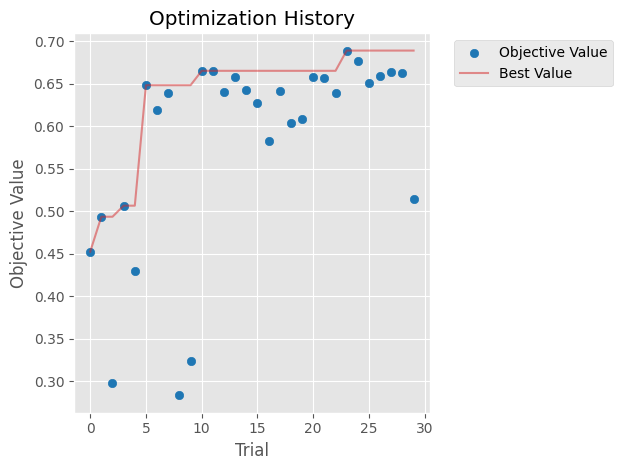

C:\Users\Andakara\AppData\Local\Temp\ipykernel_9408\34023893.py:10: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 1200x800 with 0 Axes>

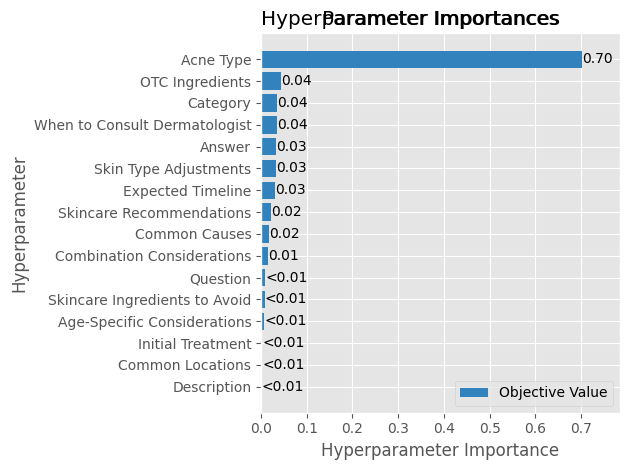

In [82]:
# Plot optimization history
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.tight_layout()
plt.show()

# Plot parameter importances
plt.figure(figsize=(12, 8))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Parameter Importances')
plt.tight_layout()
plt.show()

In [83]:
def optimized_search(query):
    """Search function with Optuna-optimized boost parameters"""
    boost = {param: float(value) for param, value in optuna_best_params.items()}
    
    results = index.search(
        query=query,
        filter_dict={},
        boost_dict=boost,
        num_results=10
    )
    
    return results

# Compare baseline vs optimized search on test data
print("Evaluating on test data...")
baseline_test_results = evaluate(test_data, lambda q: search(q))
optimized_test_results = evaluate(test_data, lambda q: optimized_search(q))

print(f"Baseline results: {baseline_test_results}")
print(f"Optimized results with Optuna: {optimized_test_results}")

# Calculate relative improvement
mrr_improvement = ((optimized_test_results['mrr'] - baseline_test_results['mrr']) / 
                   baseline_test_results['mrr']) * 100
hit_improvement = ((optimized_test_results['hit_rate'] - baseline_test_results['hit_rate']) / 
                   baseline_test_results['hit_rate']) * 100

print(f"MRR improvement: {mrr_improvement:.1f}%")
print(f"Hit rate improvement: {hit_improvement:.1f}%")

Evaluating on test data...
Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Available keys: ['id', 'question']


Evaluating questions:   0%|          | 0/70 [00:00<?, ?it/s]

Baseline results: {'hit_rate': 0.7, 'mrr': 0.25566326530612243}
Optimized results with Optuna: {'hit_rate': 0.7285714285714285, 'mrr': 0.22196712018140577}
MRR improvement: -13.2%
Hit rate improvement: 4.1%


# RAG Eval

In [84]:
import google.generativeai as genai
from dotenv import load_dotenv
import os

In [85]:
load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=api_key)

In [86]:
gemini_model = genai.GenerativeModel("gemini-2.0-flash")

In [87]:
def gemini_llm(prompt):
    """Call Gemini model with a prompt"""
    response = gemini_model.generate_content(
        prompt,
        generation_config={
            "temperature": 0.1,  # Lower temperature for evaluation
            "max_output_tokens": 500,
            "top_p": 0.95,
            "top_k": 40,
        }
    )
    return response.text

def evaluate_answer(question, answer):
    """Evaluate the relevance of an answer to a question using Gemini"""
    prompt_template = """
You are an expert evaluator for a RAG system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()
    
    prompt = prompt_template.format(question=question, answer=answer)
    evaluation = gemini_llm(prompt)
    
    # Extract JSON from the response
    try:
        # In case the model returns markdown formatting or additional text
        if '```json' in evaluation:
            json_str = evaluation.split('```json')[1].split('```')[0].strip()
        elif '{' in evaluation and '}' in evaluation:
            json_str = evaluation[evaluation.find('{'):evaluation.rfind('}')+1]
        else:
            json_str = evaluation
            
        result = json.loads(json_str)
        return result
    except json.JSONDecodeError:
        print(f"Error parsing evaluation: {evaluation}")
        return {"Relevance": "ERROR", "Explanation": "Failed to parse evaluation"}

In [88]:
def run_evaluation(sample_size=50, random_seed=42):
    """Run evaluation on a sample of questions"""
    # Load evaluation questions
    df_eval_questions = pd.read_csv('../data/knowledge-base/acne_retrieval_eval_questions.csv')
    
    # Take a random sample
    df_sample = df_eval_questions.sample(n=sample_size, random_state=random_seed)
    sample = df_sample.to_dict(orient='records')
    
    evaluations = []
    
    for record in tqdm(sample, desc="Evaluating questions"):
        question = record['question']
        # Use your existing RAG implementation
        answer = answer_question(question, model="qwen2:7b")
        
        # Evaluate with Gemini
        evaluation = evaluate_answer(question, answer)
        evaluations.append((record, answer, evaluation))
    
    return evaluations

def analyze_evaluation_results(evaluations):
    """Process and visualize evaluation results"""
    # Create DataFrame
    df_eval = pd.DataFrame(evaluations, columns=['record', 'answer', 'evaluation'])
    
    df_eval['id'] = df_eval.record.apply(lambda d: d['id'])
    df_eval['question'] = df_eval.record.apply(lambda d: d['question'])
    
    df_eval['relevance'] = df_eval.evaluation.apply(lambda d: d['Relevance'])
    df_eval['explanation'] = df_eval.evaluation.apply(lambda d: d['Explanation'])
    
    del df_eval['record']
    del df_eval['evaluation']
    
    # Display relevance statistics
    relevance_counts = df_eval.relevance.value_counts()
    relevance_percentage = df_eval.relevance.value_counts(normalize=True) * 100
    
    print("Relevance Counts:")
    print(relevance_counts)
    print("\nRelevance Percentages:")
    print(relevance_percentage)
    
    # Create a pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(relevance_counts, labels=relevance_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Answer Relevance')
    plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
    plt.tight_layout()
    plt.show()
    
    return df_eval

Evaluating questions:   0%|          | 0/10 [00:00<?, ?it/s]

Relevance Counts:
relevance
RELEVANT        9
NON_RELEVANT    1
Name: count, dtype: int64

Relevance Percentages:
relevance
RELEVANT        90.0
NON_RELEVANT    10.0
Name: proportion, dtype: float64


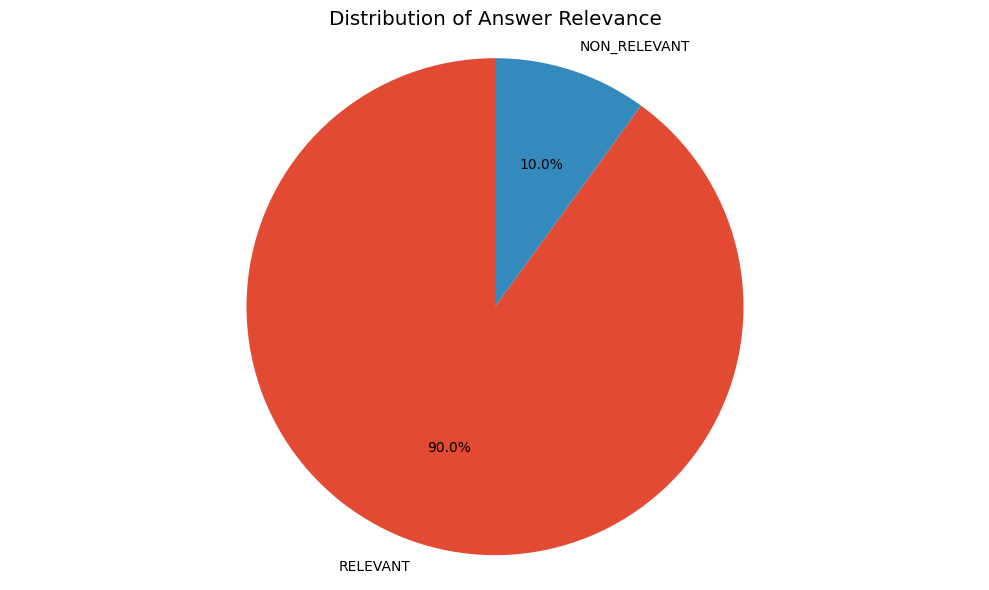


NON-RELEVANT example:
Question: Can you explain the process of lesion detection by Acne Sense?
Answer: I don't have enough information to answer that question.
Explanation: The answer states that it does not have enough information to answer the question. Therefore, it does not provide any relevant information about the lesion detection process by Acne Sense.

PARTLY_RELEVANT example:
No partly-relevant examples found

RELEVANT example:
Question: Can you explain how adult skin benefits from certain ingredients in acne management?
Answer: Certainly! Adult skin, especially when managing acne, can benefit significantly from specific ingredients tailored to its needs. Here's a breakdown:

1. **Sensitive Skin**: Ingredients like oat extract are beneficial for sensitive skin as they help soothe and calm the skin without causing irritation or drying out the skin excessively.

2. **Oily Skin**: In oily skin types, it might be advisable to use clay-based products during exfoliation sessions si

In [89]:
# Run evaluation with smaller sample size while testing
test_evaluations = run_evaluation(sample_size=10)
test_df = analyze_evaluation_results(test_evaluations)

# Look at examples of different relevance categories
print("\nNON-RELEVANT example:")
if len(test_df[test_df.relevance == 'NON_RELEVANT']) > 0:
    example = test_df[test_df.relevance == 'NON_RELEVANT'].iloc[0]
    print(f"Question: {example.question}")
    print(f"Answer: {example.answer}")
    print(f"Explanation: {example.explanation}")
else:
    print("No non-relevant examples found")

print("\nPARTLY_RELEVANT example:")
if len(test_df[test_df.relevance == 'PARTLY_RELEVANT']) > 0:
    example = test_df[test_df.relevance == 'PARTLY_RELEVANT'].iloc[0]
    print(f"Question: {example.question}")
    print(f"Answer: {example.answer}")
    print(f"Explanation: {example.explanation}")
else:
    print("No partly-relevant examples found")

print("\nRELEVANT example:")
if len(test_df[test_df.relevance == 'RELEVANT']) > 0:
    example = test_df[test_df.relevance == 'RELEVANT'].iloc[0]
    print(f"Question: {example.question}")
    print(f"Answer: {example.answer}")
    print(f"Explanation: {example.explanation}")
else:
    print("No relevant examples found")

Running full evaluation...


Evaluating questions:   0%|          | 0/50 [00:00<?, ?it/s]

Relevance Counts:
relevance
RELEVANT           39
NON_RELEVANT        6
PARTLY_RELEVANT     5
Name: count, dtype: int64

Relevance Percentages:
relevance
RELEVANT           78.0
NON_RELEVANT       12.0
PARTLY_RELEVANT    10.0
Name: proportion, dtype: float64


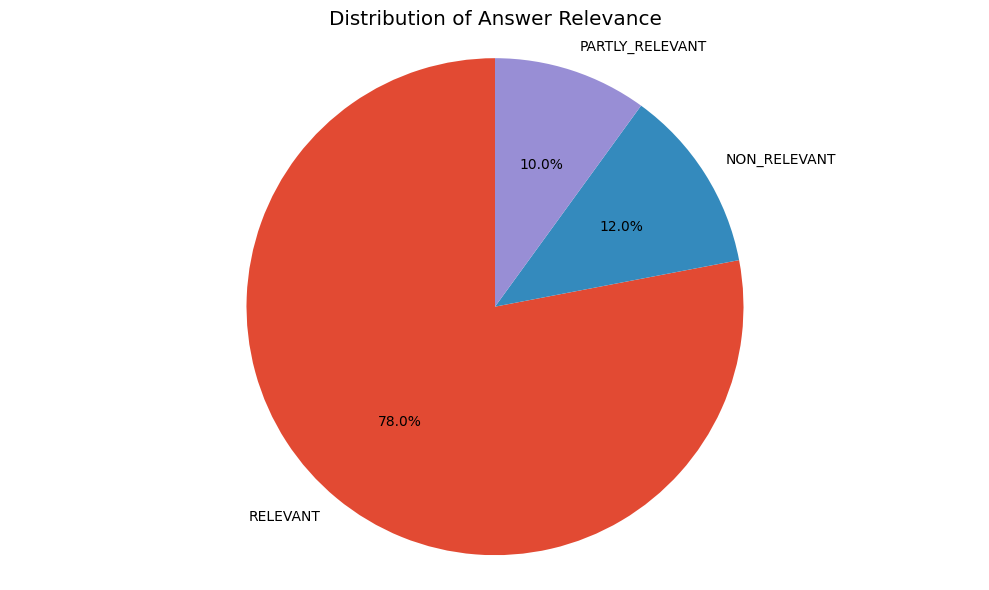

In [90]:
print("Running full evaluation...")
evaluations = run_evaluation(sample_size=50)
df_eval = analyze_evaluation_results(evaluations)

In [91]:
df_eval.to_csv('../data/knowledge-base/rag-eval-gemini.csv', index=False)
print(f"Evaluation saved to '../data/knowledge-base/rag-eval-gemini.csv'")

Evaluation saved to '../data/knowledge-base/rag-eval-gemini.csv'


In [92]:
def compare_models():
    """Compare RAG performance between Qwen and another model"""
    # Define questions for comparison
    comparison_questions = [
        "What are the best treatments for hormonal acne?",
        "How to deal with post-inflammatory hyperpigmentation?",
        "When should I see a dermatologist for my acne?",
        "What ingredients should I avoid if I have sensitive skin and acne?",
        "How long does it take to see results from retinoids?"
    ]
    
    results = []
    
    for question in comparison_questions:
        # Get answer from Qwen
        qwen_answer = answer_question(question, model="qwen2:7b")
        
        # Evaluate with Gemini
        qwen_evaluation = evaluate_answer(question, qwen_answer)
        
        # Get answer from backup model (if available)
        # backup_answer = answer_question(question, model="another_model")
        # backup_evaluation = evaluate_answer(question, backup_answer)
        
        results.append({
            "question": question,
            "qwen_answer": qwen_answer,
            "qwen_relevance": qwen_evaluation["Relevance"],
            "qwen_explanation": qwen_evaluation["Explanation"],
            # "backup_answer": backup_answer,
            # "backup_relevance": backup_evaluation["Relevance"],
            # "backup_explanation": backup_evaluation["Explanation"]
        })
    
    return pd.DataFrame(results)

# Run model comparison
model_comparison = compare_models()
print(model_comparison[["question", "qwen_relevance"]])

                                            question qwen_relevance
0    What are the best treatments for hormonal acne?       RELEVANT
1  How to deal with post-inflammatory hyperpigmen...       RELEVANT
2     When should I see a dermatologist for my acne?       RELEVANT
3  What ingredients should I avoid if I have sens...       RELEVANT
4  How long does it take to see results from reti...       RELEVANT
